###### Università degli Studi di Milano, Data Science and Economics Master Degree

# Multi-agent reinforcement learning

### Luigi Foscari

<small>see sections 1.1 to 1.4 and 5.2 to 5.4 of [Multi-Agent Reinforcement Learning: Foundations and Modern Approaches](https://www.marl-book.com) for a more in-depth overview. Consider watching this [YouTube video](https://www.youtube.com/watch?v=QfYx5q0Q75M) by the book's author which provides a great introduction.</small>

So far we tackled the problem of learning an optimal policy for a single agent inside a MDP, we now shift our focus towards contexts in which there are _multiple_ agents acting in the MDP with (possibly) different goals. For example, consider a fleet of autonomous vehicles with the goal of driving as quickly and safely as possible, a team of players in a competitive videogame or a group of automated traders that manage each their own investments in a public market.

**How does the addition of other learning agents change what we learned so far?**

_See the available [environments](https://pettingzoo.farama.org/environments/classic/) from the PettinZoo library for more examples_

A **multi-agent system** is composed of an environment and multiple decision-making agents, also called _players_, that interact in the environment to achieve certain goals. The environment evolves during play according the player's actions and optionally randomness. 

**Multi-agent reinforcement learning** or **MARL** tackles learning in such systems by devising algorithms that let the players refine their respective strategies, which can be collaborative, competitive or a mix of the two.

At the start of a round of the game, each player sees the state of the environment and picks an action, the round ends after every player has chosen an action, then the envoriment evolves accordingly and each player collects their reward to update their respective policy.

<img src="imgs/environment-marl.png" width="600" style="display: block; margin: 0 auto"/>

From the point of view of the agent, little has changed, they still have a set of actions, a policy, an enviroment and the goal of optimizing their policy.
What changed? The difference lies in the fact that **the immediate reward achieved by any player depends on the actions of the other players on the same round**.

For example consider a group of learning agents playing football, when a goal is scored, the success is tied to the actions of all the players, not only of the player that last kicked the ball. This introduces the problem of understanding how much of each player contributed, this is called **multi-agent credit assignment**.

Another issue that arises in MARL is the dependence on the number of agents, when considering games with a thousands of players, our learning procedure might struggle. When dealing with multiple agents, the algorithms will need to scale well with the number of agents.

### Central learning
One natural approach to the problem of learning with multiple agents is to use a single learning procedure (e.g. Q-learning) which learns the best strategy for each player, like a conductor in an orchestra, we shall call this algorithm the _maestro_. If each player $i \in \{1, \dots, N\}$ has an action space $\mathcal{A}_i$, then the maestro will have action space $\mathcal{A} = \mathcal{A}_1 \times \dots \times \mathcal{A}_N$, the state space is $\mathcal{S}$ and on each round the maestro chooses an action $a \in \mathcal{A}$ (where $a = (a_1, \dots, a_N)$ corresponds to actions for every single player) and distributes the correponding actions to the players, which they dutifully play as instructed. This approach can work, but it has a number of drawbacks:
- The actions space of the maestro can grows very quickly, if for example each player's action space has fixed size $A$, then the action space of the maestro has size $A^N$, which is exponential in the number of players. If each agent used an independent learning algorithm, each would have to manage only $A$ actions.
- In certain context centralized learning is not allowed, for example with autonomous driving or when the details of each agent are not known.
- Each player might have a different reward function (i.e. a different objective) and the maestro should take this into account in order to devise a complex learning objective suited to the underlying players. In practice the reward of each player might not be known and even if they are known, it might be non-trivial or downright impossible to aggregate the given rewards into a single one that can be fed to the maestro's learning procedure to achieve the desired solution concept, more on this in the next lesson.

### Independent learning
The opposite approach is for each agent to learn using an independent learning procedure, removing the need for a centralized authority, its dependency on the number of players and the issue of handling the rewards. This approach has proven to be much more successfull, but classical algorithm from RL might not be suited to the task.

#### Independent Q-learning
Consider the case in which each agents learns using the standard Q-learning algorithm. On each round, each player $i \in \{1, \dots, N\}$ observes a state $s \in \mathcal{S}$ and picks an action $a_i \in \mathcal{A}_i$, after each player picked their action $a_1, \dots, a_N$, the next state $s' = \tau(s, a)$ transitions according the joint action $a = (a_1, \dots, a_N)$ and each player receives reward $r_i$, which is used to update their respective value function $Q_i$ as
$$
	Q_i(s, a_i) =
		(1 - \alpha) Q_i(s, a_i)
		+ \alpha ( r_i + \gamma \max_{a'_i \in \mathcal{A}_i} Q_i(s', a'_i) )
$$
Because the transition from one state to another depends on the joint action $a = (a_1, \dots, a_N)$ and not on a single action, from a single player's point of view the transition function of the MDP depends on the other players actions, because the other players actively learn and are therefore non-stationary in their choice of action, the transition function is non-stationary. In general this means that independent learning does not converge to a fixed strategy unless we take into account this non-stationarity.

### The goal of multi-agent reinforcement learning
In the classic RL case, a policy is optimal if it maximises the _return_, defined as the sum of the immediate reward obtained during play, in the multi-agent case, any player's return depends on the other players' actions and ultimately depends on their policies.

**If the return of a policy depends on the other policies, how do we define optimality?** There is no fixed answer to this question, in fact it depends on the underlying context and the objective of the learning procedure, for now we only focus on modeling the problem. To understand the different solutions concepts for MARL we will rely on game-theorical arguments.

In the meantime, we can evaluate the performance of a learning algorithm by its convergence rate to a specific solution concept, viz. we define a specific policy for each player to which we want our algorithm to converge to and we try to understand
1. If the learning algorithm converges to the proposed solution (which the algorithm does not know).
2. If true, how fast is the convergence?

For example, going back to the football example, before the start of the game we decide _roughly_ how we want the players to play by defining different roles, which translate to different behaviours. Afterward we pick a learning algorithm and try to understand if the players actually learn to play as we intended.

This might seem very accidental, how can we be sure that the algorithm will converge to these behaviours that we randomly picked? This can be achieved by choosing these behaviours wisely from very well studied solution concepts, which we will tackle in the next lesson.

## From the gym to the petting zoo
The Farama foundation, who maintains the Gymnasium library, work also on a MARL-oriented library called [PettingZoo](https://pettingzoo.farama.org/). They share the same interface, which is very useful when, hypothetically, you have been following a course using Gym and now you need to abruptly switch library to cover MARL topics.

In [1]:
# Just some helper functions, nothing to see here

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def visualize(render):
	clear_output(wait=True)
	plt.imshow(render)
	plt.axis("off")
	plt.show()

def plot_reward_fit(data, title):
	x = range(len(data))
	plt.plot(x, data, "+-", alpha = .4)

	m, b = np.polyfit(x, data, 1)
	plt.plot(x, m * x + b, label = "fit")

	plt.legend()
	plt.xlabel("episode")
	plt.ylabel("reward")
	plt.title(title)
	plt.show()

### Tic-Tac-Toe

Tic-tac-toe is a classic two player stochastic game (which we will introduce in the next lesson), we use it just as a brief example of what PettingZoo can do because it is possible to force a win, making the game not so interesting.

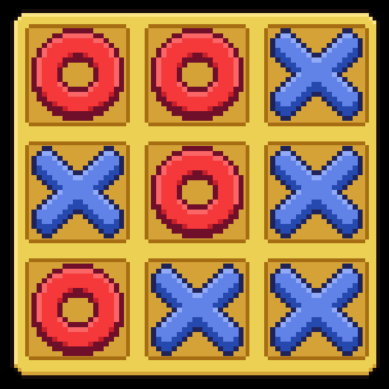

In [2]:
from pettingzoo.classic import tictactoe_v3

env = tictactoe_v3.env(render_mode = "rgb_array")
env.reset(seed = 42)

for agent in env.agent_iter():
	obs, reward, termination, truncation, info = env.last()
	if termination or truncation:
		action = None
	else:
		legal_moves = obs["action_mask"]
		action = env.action_space(agent).sample(legal_moves)

	visualize(env.render())
	env.step(action)

env.close()

### Simple Spread

We consider the game of [Simple Spread](https://pettingzoo.farama.org/environments/mpe/simple_spread/), where in a $N$ agents want to cover $N$ landmarks and are penalized if they collide with eachother (we will ignore this penalization, making the rewards uniform). The reward is the same for every agent and is the sum of the minimum distance from each landmark to the closest agent.

The action space is discrete (up, down, left, right, nothing) while the state space is continuous (the position and velocity of each agent and the position of the landmarks). The agents are drawn in blue, while the landmarks in black, the former can move freely across the map, while the latter are fixed (they move in the simulation only because the camera view is scaled to fit the contents).

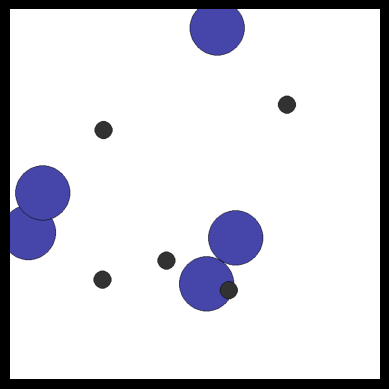

In [3]:
from pettingzoo.mpe import simple_spread_v3

NUM_AGENTS = 5

env = simple_spread_v3.parallel_env(
	N = 5,
	max_cycles = 50,
	continuous_actions = False,
	render_mode = "rgb_array"
)

observations, _ = env.reset()

while env.agents:
	actions = {agent: env.action_space(agent).sample() for agent in env.agents}

	visualize(env.render())
	observations, rewards, terminations, truncations, _ = env.step(actions)
env.close()

#### Independent Q-learning with linear approximation

To learn in the Simple Push environment we employ independent learning via Q-learning, but because the state space is very large and has a nice structure, we won't use tabular Q-learning, but instead we use a linear approximation of the value function.

The approach is the same as in the classic RL case, we have a set of weights $w$ which we want to tune to achieve a value function $Q(s, a; w)$ which is as close as possible to the true value function $Q^\star$ and in order to reach this approximation we use gradient descent.

As before, we use an approximator, in particular ```LinearQApproximator``` which handles the weights, next, we need to redefine the ```egreedy_policy_q``` function for the multiagent setting to allow different agents to have different actions sets (note that in our example the agents all have the same action set).

In [4]:
from gymbase.vfa import LinearQApproximator

NUM_AGENTS = 5

# The difference between this and egreedy_policy_q is that we require that
# the agent is known when making a prediction, because the action space can
# vary between agents. 

def multiagent_egreedy_policy_q(env, approximator, state, epsilon, agent):
	if np.random.rand() < epsilon:
		return env.action_space(agent).sample()
	return np.argmax(approximator.predict(state, action) for action in range(env.action_space(agent).n))

Next, we train a number of agents using our approximate Q-learning implementation for a fixed number of episodes. The code follows the ```q_learning``` implementation from ```gymbase/vfa.py```, the main difference is that now the MDP is updated only when **each agent** picked their respective action and only then the reward and next state are revealed.

In [5]:
from tqdm import trange
from gymbase.vfa import LinearQApproximator

def independent_qlearning(env, episodes = 100, gamma = 0.99):
	observations, _ = env.reset()

	# Each agent is represented by an instance of the LinearQApproximator class,
	# which handles the weights for the value approximation.
	approximators = {
		agent: LinearQApproximator(
			feature_extractor = lambda state: state, # identity
			num_features = observations[agent].size,
			num_actions = env.action_space(agent).n,
		) for agent in env.agents
	}


	# For simplicity in this example, this parameter is shared across learners,
	# but in general it is learner-specific.
	epsilon = 1
	min_epsilon = 0.1
	epsilon_decay = (epsilon - min_epsilon) / episodes

	# Keep track of the global rewards at the end of each episode for each agent
	episode_reward = { agent: [] for agent in env.possible_agents }

	for episode in trange(episodes, desc = "independent learning"):
		observations, _ = env.reset()

		# We care about the total reward achieved in the episode
		cumulative_episode_reward = { agent: 0 for agent in env.possible_agents }

		while env.agents:
			# Compute the action using an approximate epsilon-greedy policy
			actions = {
				agent: multiagent_egreedy_policy_q(env, approximators[agent], observations[agent], epsilon, agent)
				for agent in env.possible_agents
			}
			
			# Advance the simulation according to the action profile
			next_observations, rewards, terminations, truncations, infos = env.step(actions)

			for agent, approximator in approximators.items():
				# In general observations do not coincide with states, because
				# different agents might have different views of the environment.
				# It is not the case here.
				state, next_state = observations[agent], next_observations[agent]
				reward = rewards[agent]

				next_best_action = np.argmax(
					approximator.predict(next_state, action)
					for action in range(env.action_space(agent).n)
				)

				# We want to maximise the immediate reward + the future predicted reward
				target = reward + gamma * approximator.predict(next_state, next_best_action)

				# Update the weights of the predictor doing a step towards to gradient
				approximator.update(state, actions[agent], target)

				# Keep track of the cumulative episode reward
				cumulative_episode_reward[agent] += reward

			# We don't need the old state anymore
			observations = next_observations

		# Log the last received reward to be plotted afterward
		# Any reward is fine because it is global
		for agent in env.possible_agents:
			episode_reward[agent].append(cumulative_episode_reward[agent])

		# Encourage exploitation
		epsilon -= epsilon_decay
			
	return episode_reward

In [6]:
env = simple_spread_v3.parallel_env(
	N = NUM_AGENTS,
	max_cycles = 200,
	continuous_actions = False,
	local_ratio = 0, # we care only about global reward
)

spread_iql_reward = independent_qlearning(env)

independent learning: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


Now plot the reward accumulated for each single episode by the agents, that is, for each episode we plot the total reward gained by any agent (the rewards coincide across agents). We also show a linear fit to display that the reward is increasing.

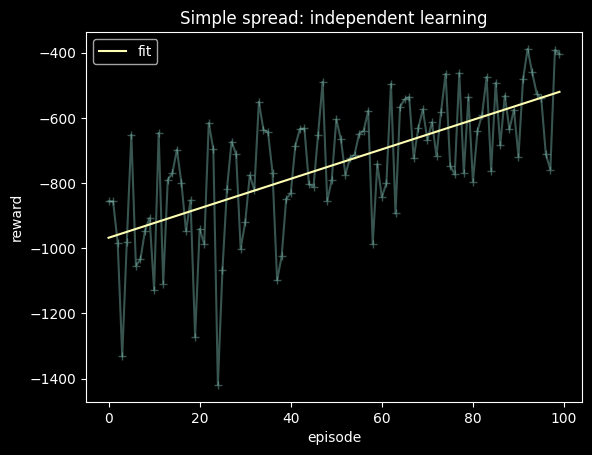

In [7]:
plot_reward_fit(spread_iql_reward["agent_0"], f"Simple spread: independent learning")

#### Global Q-learning with linear approximation

We now try to employ a single algorithm to handle the actions of all the players at the same time. For $N$ agents the actions space is $5^N$, while the state space is unchanged. In this case the step from independent learning to gloabl learning is trivial because the reward is the same for every player and we pick low values of $N$.

To achieve this, we consider a single agent, the _maestro_, which has an appropriately-sized action space.

In [8]:
def global_qlearning(env, episodes = 100, gamma = 0.99):
	observations, _ = env.reset()

	# Any agent is fine
	any_agent = "agent_0"

	maestro = LinearQApproximator(
		feature_extractor = lambda state: state, # identity
		num_features = observations[any_agent].size,
		num_actions = env.action_space(any_agent).n ** len(env.possible_agents),
	)

	epsilon = 1
	min_epsilon = 0.1
	epsilon_decay = (epsilon - min_epsilon) / episodes

	# Keep track of the global rewards at the end of each episode for each agent
	episode_reward = { agent: [] for agent in env.possible_agents }

	for episode in trange(episodes, desc = "global learning"):
		observations, _ = env.reset()

		# We care about the total reward achieved in the episode
		cumulative_episode_reward = { agent: 0 for agent in env.possible_agents }

		while env.agents:
			# Compute the global action using an approximate epsilon-greedy policy
			if np.random.rand() < epsilon:
				global_action = np.random.randint(0, 5 ** len(env.possible_agents))
			else:
				global_action = np.argmax(
					maestro.predict(observations[any_agent], action)
					for action in range(env.action_space(any_agent).n)
				)

			# Now split the global action into actions for the single agents
			# The trick is to embed N choices between 5 options into a number from 0 to 5^N,
			# consider a number in base N, then each choice is a digit in this base, we simply
			# take the least significant digit as the action, then shift the number to the
			# right and repeat.
			actions = {}
			for agent in env.possible_agents:
				actions[agent] = global_action % 5
				global_action //= 5

			# Advance the simulation according to the action profile
			next_observations, rewards, terminations, truncations, infos = env.step(actions)

			state, next_state = observations[any_agent], next_observations[any_agent]
			reward = rewards[any_agent]

			next_best_action = np.argmax(
				maestro.predict(next_state, possible_action)
				for possible_action in range(env.action_space(any_agent).n)
			)

			# We want to maximise the immediate reward + the future predicted reward
			target = reward + gamma * maestro.predict(next_state, next_best_action)

			# Update the weights of the maestro doing a step towards to gradient
			maestro.update(state, global_action, target)

			for agent in env.possible_agents:
				# Keep track of the cumulative episode reward
				cumulative_episode_reward[agent] += rewards[agent]

			# We don't need the old state anymore
			observations = next_observations

		# Log the last received reward to be plotted afterward
		# Any reward is fine because it is global
		for agent in env.possible_agents:
			episode_reward[agent].append(cumulative_episode_reward[agent])

		# Encourage exploitation
		epsilon -= epsilon_decay
			
	return episode_reward

In [9]:
env = simple_spread_v3.parallel_env(
	N = NUM_AGENTS,
	max_cycles = 200,
	continuous_actions = False,
	local_ratio = 0,
)

spread_gql_reward = global_qlearning(env)

global learning: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


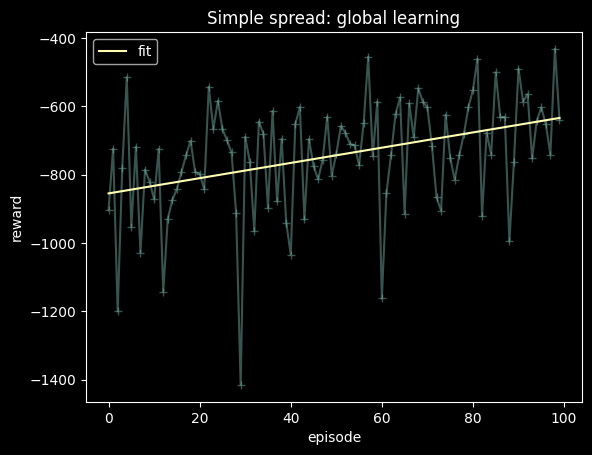

In [10]:
plot_reward_fit(spread_gql_reward["agent_0"], f"Simple spread: global learning")

#### Remarks

Both approaches seem to learn how to play the game, albeit slowly.

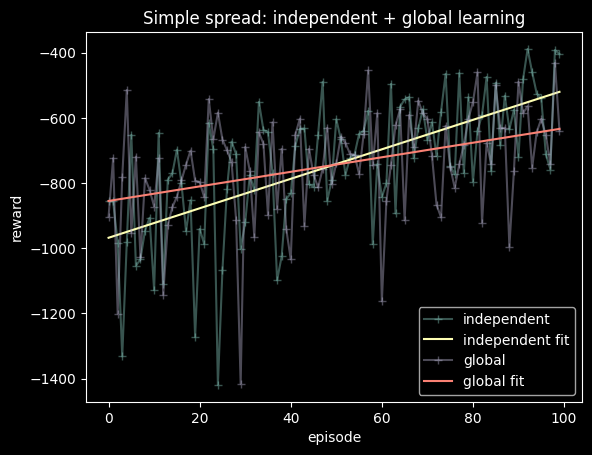

In [11]:
x = range(len(spread_gql_reward["agent_0"]))

plt.plot(x, spread_iql_reward["agent_0"], "+-", alpha = .4, label = "independent")
m, b = np.polyfit(x, spread_iql_reward["agent_0"], 1)
plt.plot(x, m * x + b, label = "independent fit")

plt.plot(x, spread_gql_reward["agent_0"], "+-", alpha = .4, label = "global")
m, b = np.polyfit(x, spread_gql_reward["agent_0"], 1)
plt.plot(x, m * x + b, label = "global fit")

plt.legend()
plt.xlabel("episode")
plt.ylabel("reward")
plt.title(f"Simple spread: independent + global learning")
plt.show()

 The global learning implementation looks like it achieves slightly better performance and seems less complicated, because we use only one algorithm, but if we try to increase the number of players, you can see that this solution does not scale.

In [12]:
env = simple_spread_v3.parallel_env(
	N = NUM_AGENTS * 4, # How big the is the global learning action space now?
)

try:
	crowded_spread_gql_reward = global_qlearning(env)
except MemoryError as e:
	print("MEMORY ERROR:", e)

MEMORY ERROR: Unable to allocate 81.3 PiB for an array with shape (95367431640625, 120) and data type float64


Imagine that you had a computer with infinite memory and infinite compute power, would you achieve better results using global learning or independent learning?

#### What about competitive games?

So far we considered the Simple push game where the reward is common to all the players, what happens if we consider another game in which this does not happen? In some sense we are introducing competition, because the players only care about their own reward, therefore they might reduce the other player's reward to increase theirs, if given the chance.

Let's consider the game [Simple Push](https://pettingzoo.farama.org/environments/mpe/simple_push/) where there are two players with competing objectives, one receives higher reward the closer they get to the landmark, while the adversary receives a higher reward if the other agent is far from the landmark, therefore needs to learn how to push the other player away from the landmark.

In [ ]:
from pettingzoo.mpe import simple_push_v3

env = simple_push_v3.parallel_env(
	continuous_actions = False,
)

push_iql_reward = independent_qlearning(env)

independent learning: 100%|██████████| 100/100 [00:01<00:00, 94.65it/s]


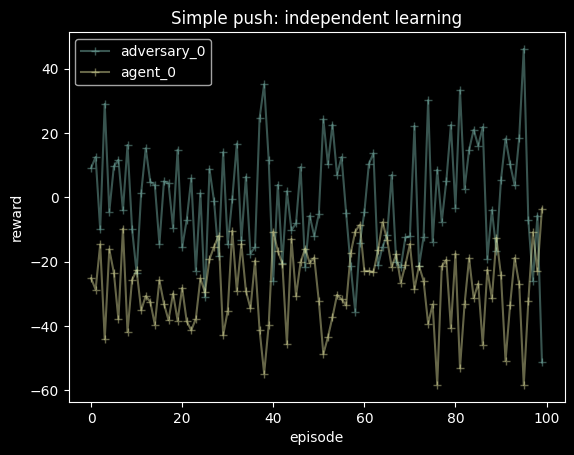

In [ ]:
for agent, reward in push_iql_reward.items():
	plt.plot(reward, "+-", alpha = .4, label = agent)

plt.legend()
plt.xlabel("episode")
plt.ylabel("reward")
plt.title(f"Simple push: independent learning")
plt.show()

This is a very intersting behaviour, the two rewards seem to go in tandem repelling each other, when one is high, the other is low and viceversa, because if the agent plays well, the adversary receives low reward and the opposite is also true.
The main problem is that the rewards of the players don't coincide, making the learning objective more difficult to understand, what would be a desireable outcome here? THe only way in which one can improve is by _stealing_ reward from the other player, so increasing both rewards is impossible.

If we were to use global learning, which reward should we use to update the _maestro_'s weights? If we use the agent's then the adversary will inevitably never learn, but if we use the adversary's then the same would happen to the adversary.

**We need a more complex learning objective.**